***
created by Farah Rabie (fr2007@hw.ac.uk)
***

<p>In this notebook, we apply two different machine learning algorithms to classify well log data based on measured geophysical properties. Specifically, we explore:</p>
<ul>
    <li><code>K-Nearest Neighbours</code> - A simple yet effective approach that classifies data points based on the majority class of their nearest neighbours.</li>
    <li><code>Random Forest</code> - An ensemble learning method that constructs multiple decision trees and aggregates their predictions for improved accuracy and robustness.</li>
</ul>
<p>By the end of this notebook, we will have a structured workflow for classifying well log data and an understanding of how different algorithms perform on geological datasets. Let’s get started!</p>

[Here](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-1.mp4) is the first video tutorial on data processing. [K-Nearest Neighbours](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-2.mp4) and [Random Forest](https://github.com/farah-rabie/GeosciencePlusAI/blob/main/Video%20Tutorials/Tutorial_3_Classification_Video-3.mp4) classification examples are also covered in the video tutorials.

##### I$\,\,\,\,\,\,$Data Processing for Classification

In [1]:
from Lib.ClassificationFunctions import DataProcessing
DataProcess = DataProcessing()

<p>Understanding the lithology distribution across different wells is crucial for the lithology classification task. We visualise the lithology distribution before processing data to gain a better understanding of the structure of the dataset. This helps identify potential issues such as class imbalances, where some lithologies might be under-represented.</p>

In [2]:
train_well_data_path = [r".\Well Data\15_9-F-11 B.csv", 
                        r".\Well Data\15_9-F-12.csv",
                        r".\Well Data\15_9-F-5.csv"]

val_well_data_path = [r".\Well Data\15_9-F-15 C.csv", 
                      r".\Well Data\15_9-F-14.csv"]

test_well_data_path = [r".\Well Data\15_9-F-4.csv",
                       r".\Well Data\15_9-F-1 B.csv"]

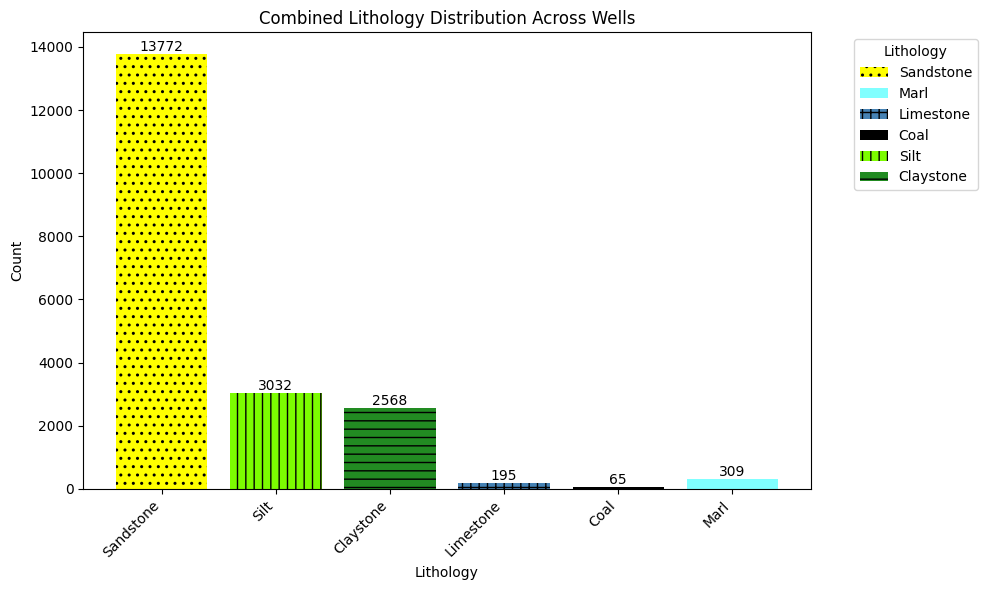

In [3]:
DataProcess.visualise_lithology_distribution(train_well_data_path)

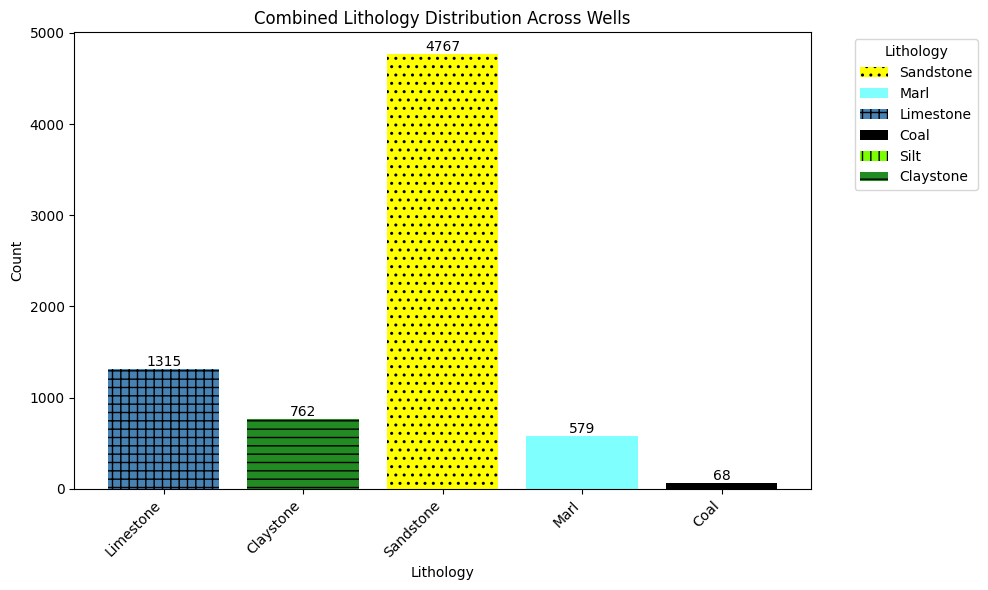

In [4]:
DataProcess.visualise_lithology_distribution(val_well_data_path)

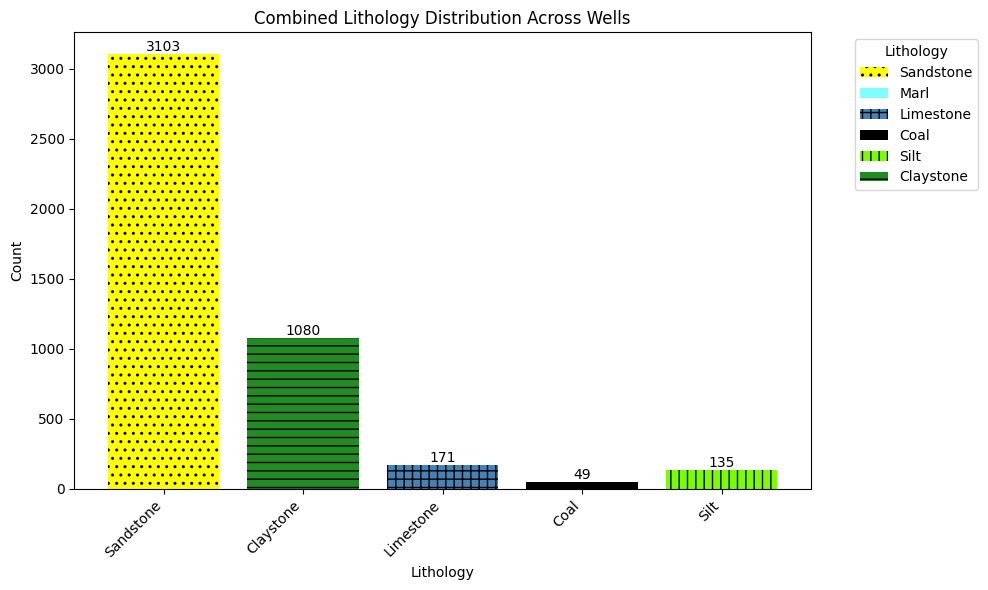

In [5]:
DataProcess.visualise_lithology_distribution(test_well_data_path)

<p>Once we have visualised the lithology distribution and identified any potential issues, we can proceed with processing the well data. Processing is a critical step to clean and transform the data into a format suitable for training machine learning models. This includes handling missing values, removing invalid data points, scaling features, and standardising the dataset. 

In [6]:
selected_columns_train = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded

processed_train_well_data = DataProcess.process_well_data(train_well_data_path, selected_columns_train, train_data=True, show_stats=True)


Descriptive Statistics of Data:
                BVW           VSH            GR          NPHI          RHOB  \
count  19941.000000  19941.000000  19941.000000  19941.000000  19941.000000   
mean       0.055563      0.301456     43.732893      0.197435      2.380937   
std        0.039040      0.213035     36.273673      0.057955      0.169176   
min        0.000000      0.026000      8.196000      0.024000      1.627000   
25%        0.025000      0.127000     20.916000      0.163000      2.235000   
50%        0.042000      0.251000     35.710000      0.190600      2.356200   
75%        0.075000      0.408500     57.848000      0.221500      2.510600   
max        0.240000      1.000000   1707.999023      0.600000      3.090000   

          log_KLOGH        log_RT  
count  19941.000000  19941.000000  
mean       3.001311      2.687735  
std        2.763702      2.027925  
min        0.000000      0.104810  
25%        0.115113      1.181420  
50%        2.343151      2.075182  
75%

In [7]:
selected_columns_val = ['BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded

processed_val_well_data = DataProcess.process_well_data(val_well_data_path, selected_columns_val, val_data=True, show_stats=True)


Descriptive Statistics of Data:
               BVW          VSH           GR         NPHI         RHOB  \
count  7482.000000  7482.000000  7482.000000  7482.000000  7482.000000   
mean      0.053502     0.333050    44.287804     0.177005     2.367450   
std       0.072908     0.175872    37.396508     0.058476     0.165489   
min       0.000000     0.000000     5.616400     0.000000     1.429500   
25%       0.029000     0.215400    28.903250     0.146600     2.224500   
50%       0.040300     0.322150    41.138201     0.176800     2.314250   
75%       0.062300     0.403700    50.599326     0.203400     2.537775   
max       1.000000     1.000000  1067.135010     0.573300     2.876200   

         log_KLOGH       log_RT  
count  7482.000000  7482.000000  
mean      2.256000     2.783468  
std       2.355098     1.823478  
min       0.000000     0.095310  
25%       0.081350     1.288282  
50%       1.502287     2.599629  
75%       3.798048     3.654112  
max      11.186140     8.517

In [8]:
selected_columns_test = ['DEPTH', 'BVW', 'KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'RT', 'LITHOLOGY'] # 'DT' and 'PEF' data were excluded

processed_test_well_data = DataProcess.process_well_data(test_well_data_path, selected_columns_test, show_stats=True)


Descriptive Statistics of DataFrame 1:
             DEPTH          BVW          VSH           GR         NPHI  \
count  2585.000000  2585.000000  2585.000000  2585.000000  2585.000000   
mean   3298.094996     0.082783     0.378572    69.434706     0.232420   
std     113.746946     0.090658     0.247979    54.812939     0.093245   
min    3101.193802     0.002900     0.048900    10.681200     0.055700   
25%    3199.644399     0.037300     0.168000    29.383600     0.171200   
50%    3298.094996     0.076000     0.274800    46.145699     0.216800   
75%    3396.545593     0.114000     0.630500   101.984398     0.269900   
max    3494.996190     1.000000     0.799800   469.738007     0.732400   

              RHOB    log_KLOGH       log_RT  
count  2585.000000  2585.000000  2585.000000  
mean      2.365990     2.572322     1.943649  
std       0.172536     3.019666     1.253026  
min       1.334100     0.000300     0.392718  
25%       2.229900     0.001000     1.037658  
50%       2

<p> Now, we standardise the three datasets to ensure that all numerical features are on the same scale. Standardisation is crucial because many machine learning algorithms perform better when the data has a consistent range. For example, features like resistivity and porosity can have vastly different scales, which might affect the performance of the model. By standardising the data, we transform it so that each feature has a mean of 0 and a standard deviation of 1. This helps the model to learn effectively and ensures that no single feature dominates due to its scale.</p>

<p>We start off with standardising the training dataset.</p>

In [9]:
standardised_train_well_data = DataProcess.standardise_dataframe(processed_train_well_data, show_stats=True)

Standardisation Parameters:
BVW: mean = 0.05556348161391103, std = 0.03903984556509878
VSH: mean = 0.301455758890828, std = 0.2130352169738318
GR: mean = 43.732893227683164, std = 36.273673402407375
NPHI: mean = 0.1974349524258563, std = 0.05795477420125635
RHOB: mean = 2.3809365774491247, std = 0.1691764176165288
log_KLOGH: mean = 3.0013114822240405, std = 2.7637024345837946
log_RT: mean = 2.6877349107346653, std = 2.0279254605541372

Descriptive Statistics of Standardised Data:
                BVW           VSH            GR          NPHI          RHOB  \
count  1.994100e+04  1.994100e+04  1.994100e+04  1.994100e+04  1.994100e+04   
mean   1.820808e-16 -2.029257e-16  4.560928e-17 -2.544143e-16  1.395626e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.423251e+00 -1.293006e+00 -9.796883e-01 -2.992591e+00 -4.456511e+00   
25%   -7.828792e-01 -8.189057e-01 -6.290207e-01 -5.941694e-01 -8.626296e-01   
50%   -3.474266e-01 -2.368423e-01 -2.2117

<p>We can then standardise the validation dataset. Enabling the <code>show_stats</code> option here allows us to confirm that the standardisation parameters are kept constant.</p>

In [10]:
standardised_val_well_data = DataProcess.standardise_dataframe(processed_val_well_data, show_stats=True)

Standardisation Parameters:
BVW: mean = 0.05556348161391103, std = 0.03903984556509878
VSH: mean = 0.301455758890828, std = 0.2130352169738318
GR: mean = 43.732893227683164, std = 36.273673402407375
NPHI: mean = 0.1974349524258563, std = 0.05795477420125635
RHOB: mean = 2.3809365774491247, std = 0.1691764176165288
log_KLOGH: mean = 3.0013114822240405, std = 2.7637024345837946
log_RT: mean = 2.6877349107346653, std = 2.0279254605541372

Descriptive Statistics of Standardised Data:
               BVW          VSH           GR         NPHI         RHOB  \
count  7482.000000  7482.000000  7482.000000  7482.000000  7482.000000   
mean     -0.052799     0.148304     0.015298    -0.352523    -0.079718   
std       1.867519     0.825552     1.030955     1.008997     0.978203   
min      -1.423251    -1.415051    -1.050803    -3.406707    -5.623932   
25%      -0.680420    -0.403951    -0.408827    -0.877149    -0.924695   
50%      -0.390972     0.097140    -0.071531    -0.356053    -0.394184 

<p>And finally, we standardise our test dataset.</p>

In [11]:
standardised_test_well_data = [] # each well has its data stored in a separate DataFrame
for df in processed_test_well_data:
    standardised_df = DataProcess.standardise_dataframe(df, show_stats=True)
    standardised_test_well_data.append(standardised_df)

Standardisation Parameters:
BVW: mean = 0.05556348161391103, std = 0.03903984556509878
VSH: mean = 0.301455758890828, std = 0.2130352169738318
GR: mean = 43.732893227683164, std = 36.273673402407375
NPHI: mean = 0.1974349524258563, std = 0.05795477420125635
RHOB: mean = 2.3809365774491247, std = 0.1691764176165288
log_KLOGH: mean = 3.0013114822240405, std = 2.7637024345837946
log_RT: mean = 2.6877349107346653, std = 2.0279254605541372

Descriptive Statistics of Standardised Data:
             DEPTH          BVW          VSH           GR         NPHI  \
count  2585.000000  2585.000000  2585.000000  2585.000000  2585.000000   
mean   3298.094996     0.697230     0.361990     0.708553     0.603661   
std     113.746946     2.322194     1.164029     1.511094     1.608925   
min    3101.193802    -1.348967    -1.185512    -0.911176    -2.445613   
25%    3199.644399    -0.467816    -0.626449    -0.395584    -0.452680   
50%    3298.094996     0.523478    -0.125124     0.066517     0.334141 

##### II$\,\,\,\,\,\,$K-Nearest Neighbours for Classification

<p>K-Nearest Neighbours (KNN) is a supervised learning algorithm used for classification and regression. It classifies a data point based on the majority class of its closest <em>k</em> neighbours in the feature space. In this notebook, we apply KNN to classify lithology types from well log data. Given a new data point, KNN will predict its lithology based on similar known samples. This approach is useful when we have well-separated clusters of lithology types.</p>

<p>We will use the <code>KNNClassification</code> function from our custom module to train a KNN classifier on the labelled well log data, predict lithology labels for new data points, and evaluate the accuracy of the trained model using metrics like confusion matrices.</p>

In [12]:
from Lib.ClassificationFunctions import KNNClassification
KNNClassifier = KNNClassification()

<p>To optimise the performance of the K-Nearest Neighbours (KNN) classifier for lithology prediction, we tune the hyperparameter <em>k</em>, which determines the number of neighbours considered for classification. A small <em>k</em> may lead to overfitting, while a large <em>k</em> cause underfitting.</p>

<p>The <code>tune_knn_k()</code> function tests different <em>k</em> values (from 1 to 10) using standardised training and validation well log data to find the optimal <em>k</em> that maximises accuracy. This ensures a balanced model that generalises well to unseen data, improving the reliability of lithology classification.</p>

Accuracy for k=1: 0.6504
Accuracy for k=2: 0.6504
Accuracy for k=3: 0.6657
Accuracy for k=4: 0.6643
Accuracy for k=5: 0.6742
Accuracy for k=6: 0.6779
Accuracy for k=7: 0.6826
Accuracy for k=8: 0.6863
Accuracy for k=9: 0.6866
Accuracy for k=10: 0.6893

Best k: 10 with accuracy: 0.6893


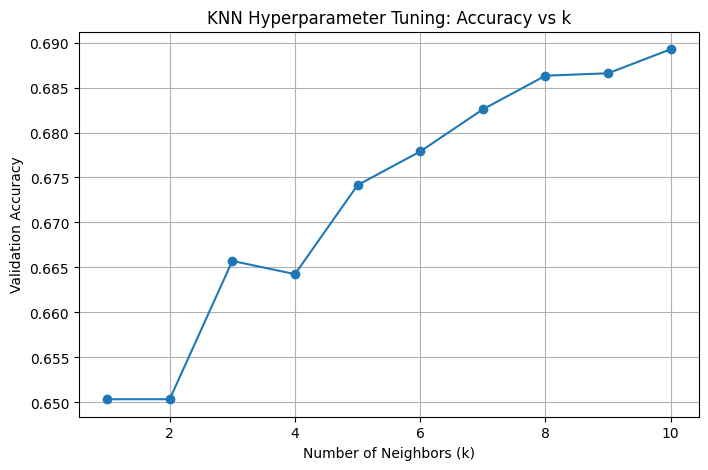

In [13]:
feature_columns = ['BVW', 'log_KLOGH', 'VSH', 'GR', 'NPHI', 'RHOB', 'log_RT']
target_column = 'LITHOLOGY'
best_k, best_knn_model, best_accuracy = KNNClassifier.tune_knn_k(standardised_train_well_data, standardised_val_well_data, feature_columns, target_column, k_max=10)

<p>After determining the optimal <em>k</em> value, we train the K-Nearest Neighbours (KNN) classifier using <em>k</em> = 5 on the standardised training well log data. The <code>train_knn()</code> function fits the model using the selected feature columns, allowing it to learn patterns in the data for lithology classification. By considering the five nearest neighbours, the model makes predictions based on majority voting, ensuring a balance between sensitivity to local variations and overall generalisation.

In [14]:
trained_KNN = KNNClassifier.train_knn(standardised_train_well_data, feature_columns, target_column, k=5)

<p>Once the KNN model is trained, we evaluate its performance on the standardised test well data. The <code>test_knn()</code> function applies the trained model to the test set, predicting lithology labels based on the selected feature columns. It returns the test accuracy, which measures how well the model generalises to unseen data, along with the predicted lithology values. This step helps assess the reliability of KNN for lithology classification in well log analysis.

In [15]:
accuracy_test_KNN, test_KNN_predicted_lithology = KNNClassifier.test_knn(trained_KNN, standardised_test_well_data[0], feature_columns, target_column)

Accuracy of KNN when tested is 0.7415860735009672


<p>To visually compare the predictions of the model with the actual lithology, we use the <code>plot_lithology_comparison()</code> function. This function generates a depth profile plot with side-by-side comparisons of the true lithology from the test dataset and the predicted lithology from the KNN model. This visualisation helps assess how well the model captures subsurface patterns and highlights any discrepancies between the predictions and actual classifications.</p>

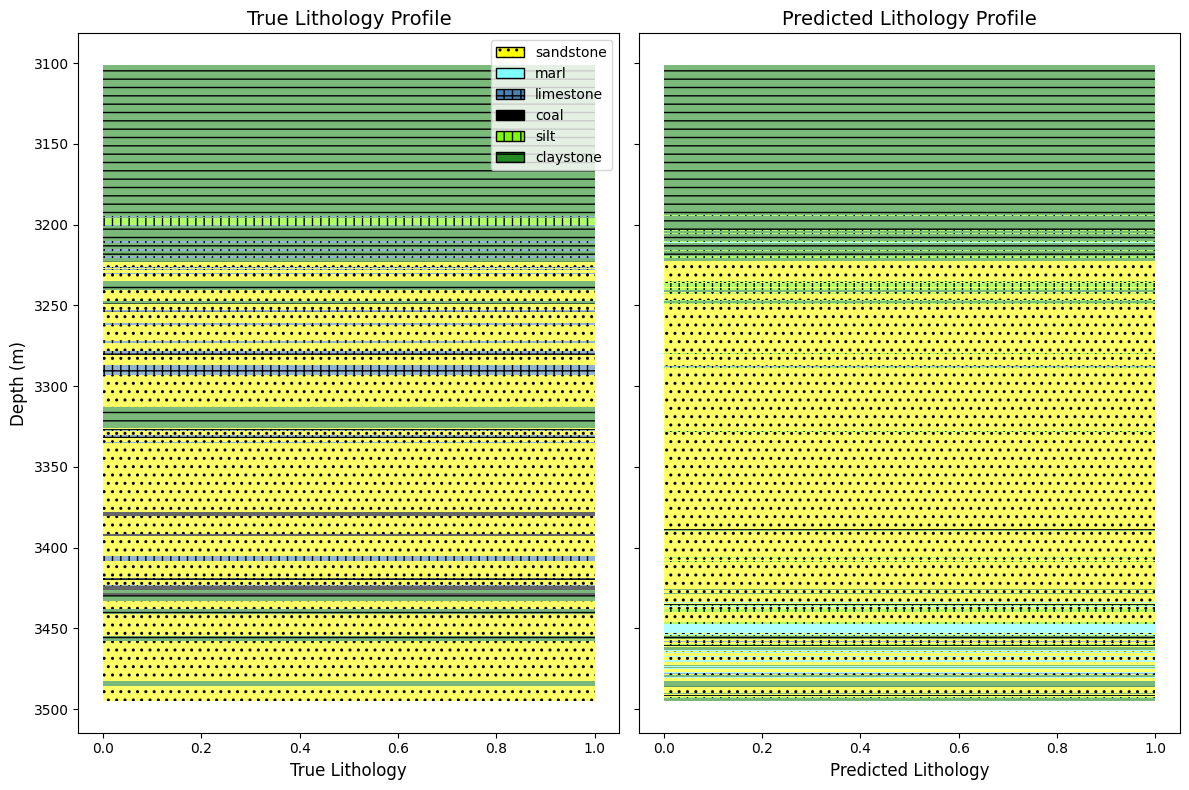

In [16]:
KNNClassifier.plot_lithology_comparison(standardised_test_well_data[0], test_KNN_predicted_lithology)

<p>We can also use the <code>plot_confusion_matrix()</code> function to evaluate the classification performance of the KNN model. This function generates a confusion matrix, which provides insights into how well the model distinguishes between different lithology classes. The matrix highlights correctly classified instances along the diagonal and misclassifications in other cells, helping to identify patterns of errors and potential areas for model improvement.</p>

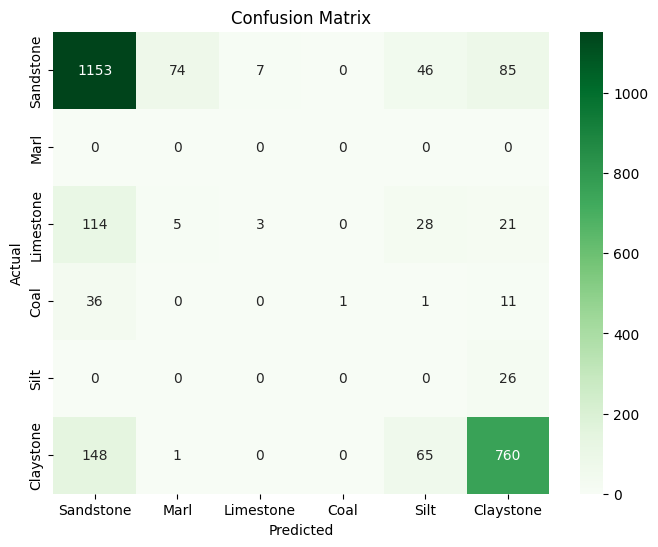

In [17]:
KNNClassifier.plot_confusion_matrix(standardised_test_well_data[0]['LITHOLOGY'].values, test_KNN_predicted_lithology)

##### III$\,\,\,\,\,\,$Random Forest for Classification

Another commonly used classifier is Random Forest, an ensemble learning method that builds multiple decision trees and combines their outputs to improve classification accuracy. This approach helps to reduce overfitting and enhances model generalisation.

In [18]:
from Lib.ClassificationFunctions import RFClassification
RFClassifier = RFClassification()

<p>To get the best performance from our Random Forest model, we use <code>RandomizedSearchCV</code> to tune hyperparameters. This method randomly samples from a predefined set of parameters, allowing us to efficiently explore different combinations without testing every possibility. Key parameters we tune include the number of trees (<code>n_estimators</code>), the maximum depth of each tree (<code>max_depth</code>), and the minimum number of samples required to split a node (<code>min_samples_split</code>).</p>
<p>The <code>tune_random_forest</code> function outputs a Random Forest model trained using the best hyperparameters found. </p>

In [19]:
trained_RF, trained_RF_params, trained_RF_accuracy, trained_RF_y_pred = RFClassifier.tune_random_forest(standardised_train_well_data, standardised_val_well_data, feature_columns, target_column)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Validation Accuracy: 0.6818

Classification Report:
               precision    recall  f1-score   support

   Claystone       0.46      0.56      0.50       762
        Coal       0.00      0.00      0.00        68
   Limestone       0.83      0.04      0.08      1315
        Marl       0.79      0.78      0.78       579
   Sandstone       0.75      0.88      0.81      4758
        Silt       0.00      0.00      0.00         0

    accuracy                           0.68      7482
   macro avg       0.47      0.38      0.36      7482
weighted avg       0.73      0.68      0.64      7482


Confusion Matrix:
 [[ 428    0    1   26  206  101]
 [   9    0    0    0   59    0]
 [  65   26   55   77  997   95]
 [  31    2    6  449   91    0]
 [ 407    1    4   13 4169  164]
 [   0    0    0    0    0    0]]


<p>After training, we evaluate the model on a separate test dataset using the <code>test_random_forest</code> function. The trained Random Forest classifier predicts lithology classes, which we can later compare to actual lithology labels. This step helps us understand how well the model generalises to new data.</p>
<p>To assess model performance, we calculate the <code>accuracy score</code> to get a quantitative measure of performance. We also use a <code>confusion matrix</code> to show how well the classifier distinguishes between different lithology types. These visualisations help us interpret the model’s strengths and areas for improvement.</p>

In [20]:
accuracy_test_RF, test_RF_predicted_lithology = RFClassifier.test_random_forest(trained_RF, standardised_test_well_data[0], feature_columns, target_column)

Test Accuracy: 0.8217
Confusion Matrix:
 [[ 822    0    0    3  139   10]
 [   4   13    0    0   32    0]
 [  30    0    0    0  123   18]
 [   0    0    0    0    0    0]
 [  66    0    2    0 1289    8]
 [  26    0    0    0    0    0]]


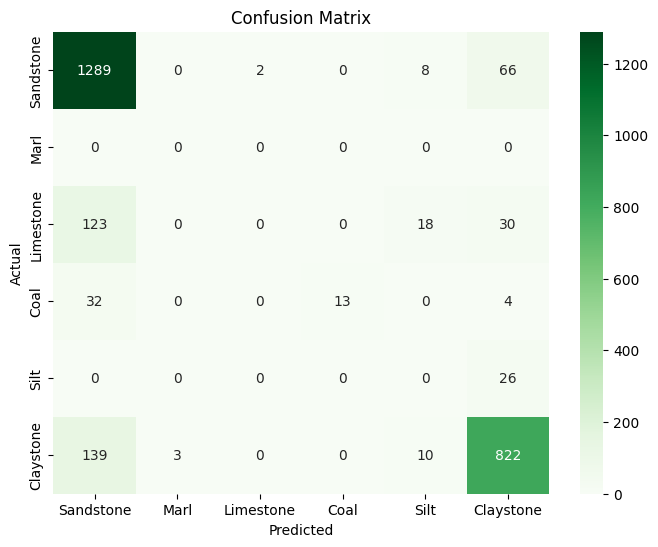

In [21]:
KNNClassifier.plot_confusion_matrix(standardised_test_well_data[0]['LITHOLOGY'].values, test_RF_predicted_lithology)

<p>Similar to the earlier section, we can also use the <code>plot_lithology_comparison</code> function to visually compare the predicted lithology labels from the trained Random Forest model with the actual lithology labels in the test dataset.</p>

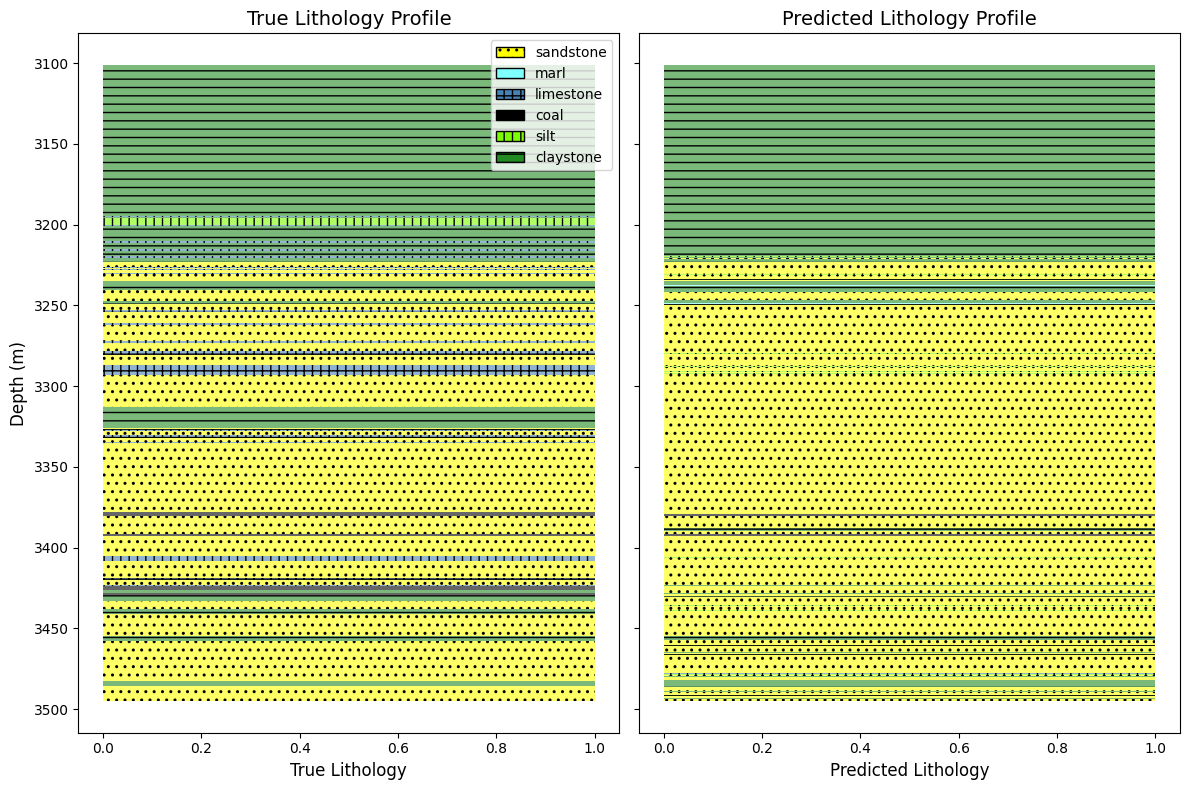

In [22]:
KNNClassifier.plot_lithology_comparison(standardised_test_well_data[0], test_RF_predicted_lithology)